In [12]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ms_deisotope import deconvolute_peaks, averagine, scoring
from ms_deisotope.deconvolution import peak_retention_strategy
import json
from os.path import expanduser

In [13]:
experiment_base_dir = '/media/big-ssd/experiments'
experiment_name = 'P3856'
precursor_definition_method = 'pasef'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = "{}/{}".format(experiment_base_dir, experiment_name)

In [14]:
# select a precursor cuboid id to visualise
# FEATURES_DIR = "{}/features-{}".format(EXPERIMENT_DIR, precursor_definition_method)
# FEATURES_DEDUP_FILE = '{}/exp-{}-run-{}-features-{}-dedup.pkl'.format(FEATURES_DIR, experiment_name, run_name, precursor_definition_method)
# d = pd.read_pickle(FEATURES_DEDUP_FILE)
# features_df = d['features_df']
# precursor_cuboid_id = features_df.sample(n=1).iloc[0].precursor_cuboid_id
# precursor_cuboid_id

# some good precursors for analysis
# precursor_cuboid_id = 23911
precursor_cuboid_id = 18601
# precursor_cuboid_id = 35173

In [15]:
VIS_FILE = '{}/feature-detection-{}-visualisation-{}.pkl'.format(expanduser("~"), precursor_definition_method, precursor_cuboid_id)

In [16]:
# load the visualisation file for this precursor cuboid
vis_d = pd.read_pickle(VIS_FILE)
vis_d.keys()

dict_keys(['precursor_cuboid_d', 'wide_ms1_points_df', 'fe_ms1_points_df', 'peaks_after_intensity_descent', 'deconvolution_features_df', 'features_df'])

In [17]:
features_df = vis_d['features_df']
features_df

,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,intensity_without_saturation_correction,intensity_with_saturation_correction,...,charge,monoisotopic_mass,feature_intensity,envelope,isotope_count,deconvolution_score,precursor_cuboid_id,fragment_ions_l,fmdw_before_after_d,feature_id
0,817.910278,817.962341,492.0,456,527,1812.938232,1809.233398,1816.11438,3307,3307,...,2,1633.858032,3307,"[[817.9363193873662, 28687.0], [818.4375470126...",4,388.130371,18601,"[{""singly_protonated_mass"": 209.1077, ""neutral...","{'ms2_points_l': [{'mz': 619.3258019431919, 'i...",1860101
1,818.884277,818.936462,489.0,466,518,1810.820801,1807.115479,1816.11438,4357,4357,...,2,1635.803101,4357,"[[818.9103842802886, 25258.0], [819.4105121369...",4,310.311859,18601,"[{""singly_protonated_mass"": 209.1077, ""neutral...","{'ms2_points_l': [{'mz': 619.3258019431919, 'i...",1860102
2,815.389221,815.441162,466.0,452,514,1811.879395,1808.704468,1815.05481,1676,1676,...,1,814.407898,1676,"[[815.4151939403328, 13868.0], [816.4231483758...",3,155.319870,18601,"[{""singly_protonated_mass"": 209.1077, ""neutral...","{'ms2_points_l': [{'mz': 619.3258019431919, 'i...",1860103


In [18]:
selected_feature_number = 1
selected_feature = features_df.iloc[selected_feature_number-1]
selected_feature_id = selected_feature.feature_id
selected_feature_id

1860101

In [19]:
ms2_points_l = selected_feature.fmdw_before_after_d['ms2_points_l']

In [20]:
ms2_points_df = pd.DataFrame(ms2_points_l)

In [21]:
ms2_points_df['normalised_intensity'] = ms2_points_df.intensity / ms2_points_df.intensity.max()

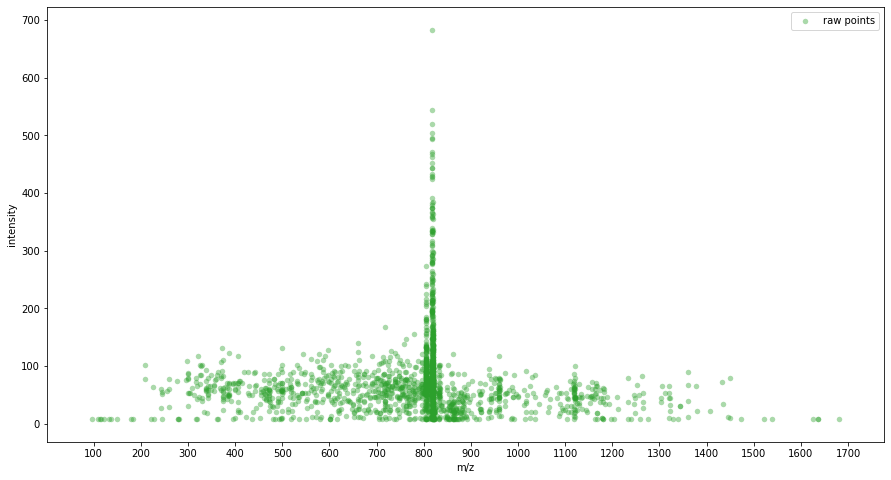

In [22]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(ms2_points_df.mz, ms2_points_df.intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4, label='raw points')

plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 100.0
range_l = round(ms2_points_df.mz.min() / nearest) * nearest
range_u = round(ms2_points_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.margins(0.06)
plt.legend(loc='best')
# plt.title('raw ms2 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_cuboid_id, run_name, experiment_name))
plt.show()

In [23]:
fragment_ions_before_df = pd.DataFrame(selected_feature.fmdw_before_after_d['before_fmdw'])
fragment_ions_before_df['normalised_intensity'] = fragment_ions_before_df.intensity / fragment_ions_before_df.intensity.max()

fragment_ions_after_df = pd.DataFrame(selected_feature.fmdw_before_after_d['after_fmdw'])
fragment_ions_after_df['normalised_intensity'] = fragment_ions_after_df.intensity / fragment_ions_after_df.intensity.max()


In [24]:
reduced_by = (len(fragment_ions_before_df) - len(fragment_ions_after_df)) / len(fragment_ions_before_df) * 100
print('{} ions before, {} ions after, {}% reduction'.format(len(fragment_ions_before_df), len(fragment_ions_after_df), round(reduced_by)))

108 ions before, 85 ions after, 21% reduction


In [ ]:
mass_lower = 650
mass_upper = 850

In [27]:
subset_before_df = fragment_ions_before_df[(fragment_ions_before_df.neutral_mass >= mass_lower) & (fragment_ions_before_df.neutral_mass <= mass_upper)].copy()
subset_after_df = fragment_ions_after_df[(fragment_ions_after_df.neutral_mass >= mass_lower) & (fragment_ions_after_df.neutral_mass <= mass_upper)].copy()

In [28]:
subset_before_df['normalised_intensity'] = subset_before_df.intensity / subset_before_df.intensity.max()
subset_after_df['normalised_intensity'] = subset_after_df.intensity / subset_after_df.intensity.max()

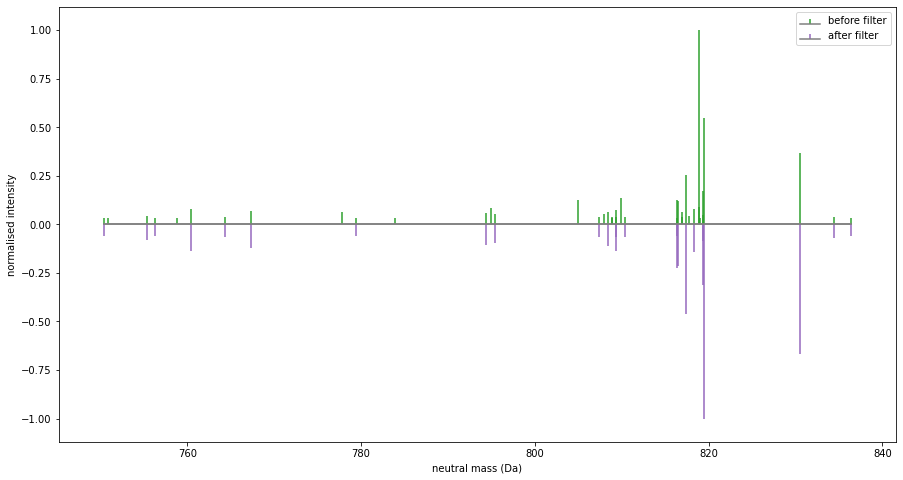

In [30]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# plot the raw data
markerline, stemlines, baseline = ax.stem(subset_before_df.neutral_mass, subset_before_df.normalised_intensity, markerfmt=" ", use_line_collection=True, label='before filter')
plt.setp(markerline, 'color', 'tab:green')
plt.setp(stemlines, 'color', 'tab:green')
plt.setp(baseline, 'color', 'tab:gray')

# plot the filtered data
markerline, stemlines, baseline = ax.stem(subset_after_df.neutral_mass, -subset_after_df.normalised_intensity, markerfmt=" ", use_line_collection=True, label='after filter')
plt.setp(markerline, 'color', 'tab:purple')
plt.setp(stemlines, 'color', 'tab:purple')
plt.setp(baseline, 'color', 'tab:gray')

plt.xlabel('neutral mass (Da)')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.legend(loc='best')
# plt.title('fragment ions before and after filtering by mass defect windows\nprecursor cuboid {}, experiment {}, run {}'.format(precursor_cuboid_id, experiment_name, run_name))
plt.show()